In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
from scipy.stats import linregress 
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from threading import Thread

%matplotlib inline
#plt.rcParams['figure.figsize'] = (5, 4)
sns.set(style="whitegrid", color_codes=True, context="poster")

mainpath = '/Users/jorgetil/Astro/HITS'

In [16]:
#Random walk
def random_walk(n_sample):
    N = 2000
    alpha = 1
    sigma = 0.5
    rw_lcs = []
    n =0
    while n < n_sample:
        mag_rw = np.zeros([N,1])
        err_rw = np.zeros([N,1])
        mag_rw[0] = 1

        time_rw = xrange(1, N)

        for t in time_rw:
            mag_rw[t] = alpha * mag_rw[t-1] + np.random.normal(loc=0.0,
                                                               scale=sigma)

        time_rw = np.array(range(0,N)) + 1*np.random.uniform(size = N)
        mag_rw = mag_rw.squeeze()
        lc = np.array([time_rw, mag_rw])
        rw_lcs.append(lc.T)
        n += 1
    return rw_lcs
    # plt.plot(time_rw,mag_rw,'b.', label = 
    #         'Random Walk\n loc = %i\n scale = %.1f' % (0, sigma))
    # plt.legend(loc = 'best')
    # plt.show()

In [17]:
#Normal
def random_normal(n_sample):
    N = 2000
    alpha = 1
    sigma = 0.5
    normal_lcs = []
    n =0
    while n < n_sample:
        mag_normal = np.random.normal(size=N)
        time_normal = np.arange(N)
        lc = np.array([time_normal, mag_normal])
        normal_lcs.append(lc.T)
        n += 1
    return normal_lcs

In [18]:
#Structure function by Isa Nun

def structure_function_in(time, mag, Nsf=100, Np=100):
    sf = np.zeros(Nsf)
    sf2 = np.zeros(Nsf)
    sf3 = np.zeros(Nsf)
    f = interp1d(time, mag)
    #time_int = np.linspace(np.min(time),
    #                       np.int64((np.min(time)+np.max(time)))/2.0, Np)
    time_int = np.linspace(np.min(time), np.max(time), Np)
    mag_int = f(time_int) 
    # this for is to calculate all the difference between 2 mag
    # separeted by tau time_lag
    # and then averaging
    for tau in np.arange(1, Nsf):
        # tau is a time_lag in index unit (1,2,3...)
        sf[tau-1]=np.mean(np.power(
                np.abs(mag_int[0:Np-tau] - mag_int[tau:Np]) , 1.0))
        sf2[tau-1]=np.mean(np.power(
                    np.abs( mag_int[0:Np-tau] - mag_int[tau:Np]) , 2.0))
        sf3[tau-1]=np.mean(np.power(
                    np.abs( mag_int[0:Np-tau] - mag_int[tau:Np]) , 3.0))
    return mag_int, time_int, sf, sf2, sf3

In [19]:
def SF_ratios(SF1, SF2, SF3):
    m_21, b_21 = np.polyfit(SF1,SF2, 1)
    m_32, b_32 = np.polyfit(SF2,SF3, 1)
    m_31, b_31 = np.polyfit(SF1,SF3, 1)
    return m_21, m_31, m_32, b_21, b_31, b_32

In [20]:
# load MACHO LC from trainig set
def extract_MACHO(lcs_path):

    member_names = np.sort(glob.glob('%s/lc_*.mjd' % (lcs_path)),
                           kind='mergesort')
    done_ids = []
    LCS_R, LCS_B = [], []
    for member_name in member_names:
        present = -1 # 0 = Both, 1 = B, 2 = R
        prefix = None
        id_ = None
        if member_name.endswith("B.mjd"):
            prefix = member_name[:-5]
            id_ = prefix[prefix.rfind('_')+1:-1]
            if prefix + 'R.mjd' in member_names:
                present = 0
            else:
                present = 1
        elif member_name.endswith("R.mjd"):
            prefix = member_name[:-5]
            id_ = prefix[prefix.rfind('_')+1:-1]
            if prefix + 'B.mjd' in member_names:
                present = 0
            else:
                present = 2
        prefix = os.path.basename(prefix)
        if id_ is not None and not id_ in done_ids:
            if present == 0:
                lc_B = pd.read_csv('%s/%sB.mjd' % (lcs_path, prefix)
                                   , header=2, delimiter=' ')
                lc_R = pd.read_csv('%s/%sR.mjd' % (lcs_path, prefix)
                                   , header=2, delimiter=' ')
                LCS_R.append(lc_R)
                LCS_B.append(lc_B)
            done_ids.append(id_)
                
    return LCS_R, LCS_B

In [21]:
M_LCS_R_QS, M_LCS_B_QS = extract_MACHO('%s/MACHO/QSO' % (mainpath))
print len(M_LCS_R_QS), len(M_LCS_B_QS)
M_LCS_QS = [M_LCS_R_QS, M_LCS_B_QS]
M_LCS_QS = [item for sublist in M_LCS_QS for item in sublist]
print len(M_LCS_QS)

59 59
118


In [22]:
M_LCS_R_NV, M_LCS_B_NV = extract_MACHO('%s/MACHO/NV' % (mainpath))
print len(M_LCS_R_NV), len(M_LCS_B_NV)
M_LCS_NV = [M_LCS_R_NV, M_LCS_B_NV]
M_LCS_NV = [item for sublist in M_LCS_NV for item in sublist]
print len(M_LCS_NV)

4490 4490
8980


In [23]:
M_LCS_R_RR, M_LCS_B_RR = extract_MACHO('%s/MACHO/periodic/RRL' % (mainpath))
print len(M_LCS_R_RR), len(M_LCS_B_RR)
M_LCS_RR = [M_LCS_R_RR, M_LCS_B_RR]
M_LCS_RR = [item for sublist in M_LCS_RR for item in sublist]
print len(M_LCS_RR)

610 610
1220


In [24]:
M_LCS_R_CP, M_LCS_B_CP = extract_MACHO('%s/MACHO/periodic/CEPH' % (mainpath))
print len(M_LCS_R_CP), len(M_LCS_B_CP)
M_LCS_CP = [M_LCS_R_CP, M_LCS_B_CP]
M_LCS_CP = [item for sublist in M_LCS_CP for item in sublist]
print len(M_LCS_CP)

101 101
202


In [25]:
def power_law(tau, gamma, a):
    return tau*gamma + a

In [26]:
labels = ['QSO' for k in range(len(M_LCS_QS))]
labels.extend(['NV' for k in range(len(M_LCS_NV[:200]))])
labels.extend(['RRLYR' for k in range(len(M_LCS_RR))])
labels.extend(['CEP' for k in range(len(M_LCS_CP))])

colors = ['b' for k in range(len(M_LCS_QS))]
colors.extend(['r' for k in range(len(M_LCS_NV[:200]))])
colors.extend(['c' for k in range(len(M_LCS_RR))])
colors.extend(['g' for k in range(len(M_LCS_CP))])

all_LCS_M = [M_LCS_QS, M_LCS_NV[:200], M_LCS_RR, M_LCS_CP]
all_LCS_M = [item for sublist in all_LCS_M for item in sublist]
print len(all_LCS_M), len(labels)

1740 1740


In [27]:
# Structure function S10 (Schmidt et al. 2010) and S84
#(Simonetti et a. 1984)

def structure_function_jm(time, mag, err = [None], N = 100):
    
    #print mag.shape
    # V matrix with magnitude variance between times
    # delta_t matrix with time interval for all datapoints
    # therefore these matrix are upper trinagle
    M = len(mag)
    time -= np.min(time)
    if err[0] == None:
        err = np.zeros(mag.shape)

    # V and delta_t have shape M(M-1)/2, with M = len(mag)
    # amount of datapoints
    delta_t = np.abs(np.subtract.outer(time, time))
    delta_mag = np.abs(np.subtract.outer(mag, mag))
    delta_err = np.abs(np.add.outer(err**2, err**2))
    #print delta_t.shape
    iu1 = np.triu_indices_from(delta_t, 1)
    delta_t = delta_t[iu1]
    delta_mag = delta_mag[iu1]
    delta_err = delta_err[iu1]
    
    S10 = np.sqrt(np.pi/2)*np.abs(delta_mag) + np.sqrt(delta_err)
    
    # tau are bins of time interval
    # SF is calculated as mean of all epoch pairs i,j whose lag 
    # falls in tau bins
    year = 365.25
    tau_bin = np.linspace(0, np.max(delta_t), N+1)
    tau = []
    
    S10_avg = np.zeros(N)
    tau = np.zeros(N)
    SF84_1 = np.zeros(N)
    SF84_2 = np.zeros(N)
    SF84_3 = np.zeros(N)
    #print len(V_S84)

    for n in range(0,N):
        #print 'days'
        #print 'tau <= %f' % (tau[n])
        mask_t = (delta_t >= tau_bin[n]) & (delta_t <= tau_bin[n+1])
        #print '[%.3f, %.3f] # of points = %i' % (tau[n-1], tau[n],
        #                                         len(V_S84[mask_t]))
        #SF84_1[n] = np.mean(V_S84[mask_t]**1)#/M
        #SF84_2[n] = np.mean(V_S84[mask_t]**2)#/M
        #SF84_3[n] = np.mean(V_S84[mask_t]**3)#/M
        S10_avg[n] = np.mean(S10[mask_t])
        tau[n] = (tau_bin[n] + tau_bin[n+1])/2
        #print '_______________________________'

    return tau, S10_avg
'''
without the for!!

bins = np.linspace(0,np.max(tau), N)
tuple_list = zip(bin[:-1], bin[1:])
bin_arr = np.array(tuple_list).reshape(N+1,2)
S10_avg = map(lamda i: np.mean(S10[(delta_t>i[0])&(delta_t<i[1])]))
'''

'\nwithout the for!!\n\nbins = np.linspace(0,np.max(tau), N)\ntuple_list = zip(bin[:-1], bin[1:])\nbin_arr = np.array(tuple_list).reshape(N+1,2)\nS10_avg = map(lamda i: np.mean(S10[(delta_t>i[0])&(delta_t<i[1])]))\n'

In [28]:
#plt.figure(figsize=(6,8))
gamma_, A_ = [], []
for k, lc in enumerate(all_LCS_M):
    print '\r %i' % (k+1), len(lc),
    time, mag, err = lc['#MJD'], lc['Mag'], lc['Err']
    #time , mag = lc[:,0], lc[:,1]
    #tau, SF84_1, SF84_2, SF84_3 = structure_function_jm(time, mag, N=25)
    tau, S10 = structure_function_jm(time, mag, err=err, N=25)
    log_tau = np.log10(tau)
    log_S10 = np.log10(S10)
    popt, pcov = curve_fit(power_law, log_tau, log_S10)#, bounds=([0.,0.], [np.inf,1.]))
    gamma_.append(popt[0])
    A_.append(10**popt[1])
    
    if False:
        tt = np.linspace(np.min(log_tau), np.max(log_tau), 100)
        plt.plot(log_tau, log_S10, c=colors[k], ls='-', lw=1, label='S84*2', alpha=.5)
        plt.plot(tt, tt*popt[0] + popt[1], c=colors[k], ls='--', lw=.8)

        #SF_jm_x = np.linspace(SF84_1_log.min(), SF84_1_log.max(), 1000)
        #ax[1].plot(SF_jm_x, SF_jm_x * m_31_jm + b_31_jm, 'r-', label=m_31_jm)
        #SF_in_x = np.linspace(sf_log.min(), sf_log.max(), 1000)
        #ax[1].plot(SF_in_x, SF_in_x * m_31_in + b_31_in, 'r--', label=m_31_in)

        #ax.legend(loc='best')
#plt.yscale('log')
#plt.xscale('log')
#plt.show()
gamma_ = np.array(gamma_, dtype=float)
A_ = np.array(A_, dtype=float)

 1740 1068


In [15]:
SF_fit = pd.DataFrame(np.array([labels, A_, gamma_]).T, columns=['Class','A','gamma'])

qso_fit = SF_fit.query('Class == "QSO"')
rrl_fit = SF_fit.query('Class == "RRLYR"')
nvv_fit = SF_fit.query('Class == "NV"')
cep_fit = SF_fit.query('Class == "CEP"')

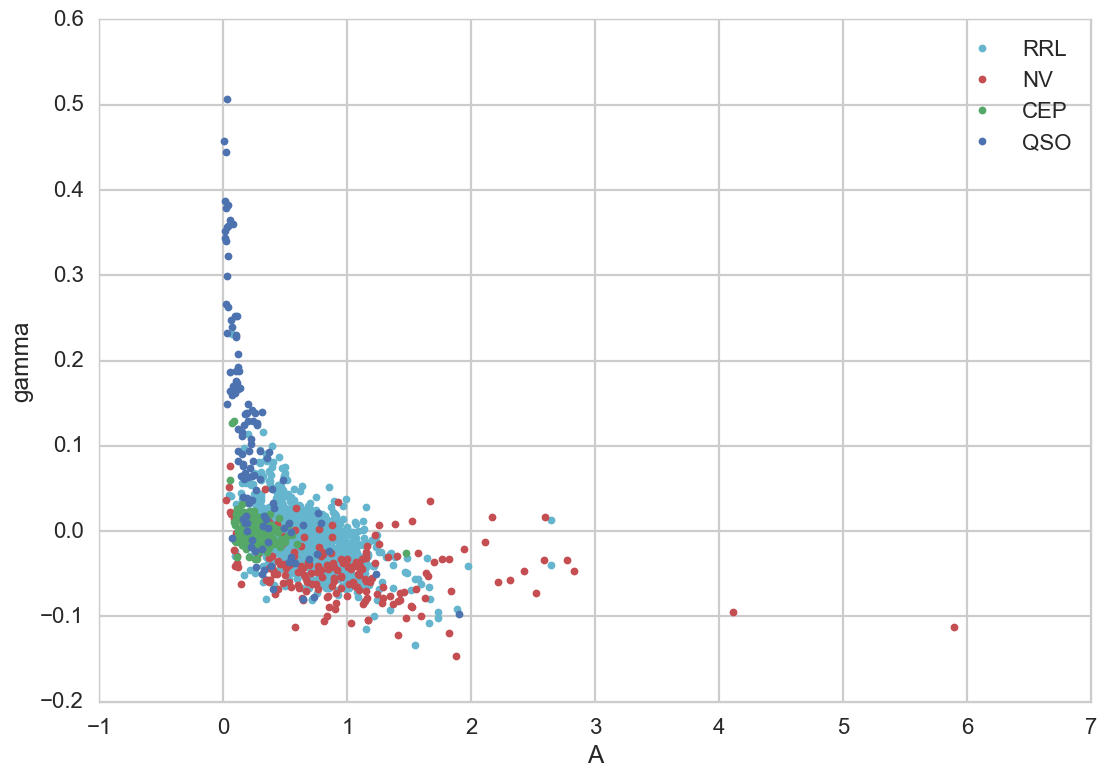

In [16]:
plt.plot(rrl_fit.A, rrl_fit.gamma, '.c', label='RRL')
plt.plot(nvv_fit.A, nvv_fit.gamma, '.r', label='NV')
plt.plot(cep_fit.A, cep_fit.gamma, '.g', label='CEP')
plt.plot(qso_fit.A, qso_fit.gamma, '.b', label='QSO')
plt.legend(loc='best')
plt.xlabel('A')
plt.xlim(-1,7)
plt.ylabel('gamma')
plt.show()

In [17]:
SF_fit.head()

,Class,A,gamma
0,QSO,1.22699456823,-0.0500491302898
1,QSO,0.232605433579,0.142260336121
2,QSO,0.52662059229,0.00900124103423
3,QSO,0.176758235499,0.00942836098929
4,QSO,0.125315509832,0.187708808168


In [19]:
import FATS
for k,lc in enumerate(all_LCS_M[:10]):
    print '\r %i' % (k+1), len(lc),
    time, mag, err = lc['#MJD'], lc['Mag'], lc['Err']
    a = FATS.FeatureSpace(featureList=['StructureFunction_index_21',
                                       'StructureFunction_index_31',
                                       'StructureFunction_index_32',
                                       'SF_A', 'SF_gamma'])
    a=a.calculateFeature(np.array([mag,time,err]))
    
    print a.result(method='dict')
    print '_______________________'

 1 503  could not find feature SF_A


SystemExit: 1

In [87]:
RW_SF_JM = {'2/1':[], '3/1':[], '3/2':[]}
RW_SF_IN = {'2/1':[], '3/1':[], '3/2':[]}
for k,lc in enumerate(RW_LCS):
    print '\r %i' % (k+1),
    time , mag = lc[:,0], lc[:,1]
    ## calculate SF
    #tau, SF84_1, SF84_2, SF84_3 = structure_function_jm(time, mag)
    mag_int, time_int, sf, sf2, sf3 = \
                                structure_function_in(time, mag)
    ## convert to log
    #SF84_1_log = np.log10(np.trim_zeros(SF84_1))
    #SF84_2_log = np.log10(np.trim_zeros(SF84_2))
    #SF84_3_log = np.log10(np.trim_zeros(SF84_3))
    sf_log = np.log10(np.trim_zeros(sf))
    sf2_log = np.log10(np.trim_zeros(sf2))
    sf3_log = np.log10(np.trim_zeros(sf3))
    ## fit linear rel
    #m_21_jm, m_31_jm, m_32_jm, b_21_jm, b_31_jm, b_32_jm =\
    #                            SF_ratios(SF84_1_log, SF84_2_log, SF84_3_log)
    m_21_in, m_31_in, m_32_in, b_21_in, b_31_in, b_32_in =\
                                SF_ratios(sf_log, sf2_log, sf3_log)
        
    #RW_SF_JM['2/1'].append(m_21_jm)
    #RW_SF_JM['3/1'].append(m_31_jm)
    #RW_SF_JM['3/2'].append(m_32_jm)
    RW_SF_IN['2/1'].append(m_21_in)
    RW_SF_IN['3/1'].append(m_31_in)
    RW_SF_IN['3/2'].append(m_32_in)
    
    ## plots
    if False:
        f, ax = plt.subplots(2)
        ax[0].plot(time, mag, 'k.')
        ax[1].plot(SF84_1_log, SF84_3_log, 'g.', label='JM')
        ax[1].plot(sf_log, sf3_log, 'b.', label='IN')

        SF_jm_x = np.linspace(SF84_1_log.min(), SF84_1_log.max(), 1000)
        ax[1].plot(SF_jm_x, SF_jm_x * m_31_jm + b_31_jm, 'r-', label=m_31_jm)
        SF_in_x = np.linspace(sf_log.min(), sf_log.max(), 1000)
        ax[1].plot(SF_in_x, SF_in_x * m_31_in + b_31_in, 'r--', label=m_31_in)

        ax[1].legend(loc='lower right')
    plt.show()
    
#RW_SF_JM = pd.DataFrame(RW_SF_JM)
RW_SF_IN = pd.DataFrame(RW_SF_IN)

 4232

KeyboardInterrupt: 

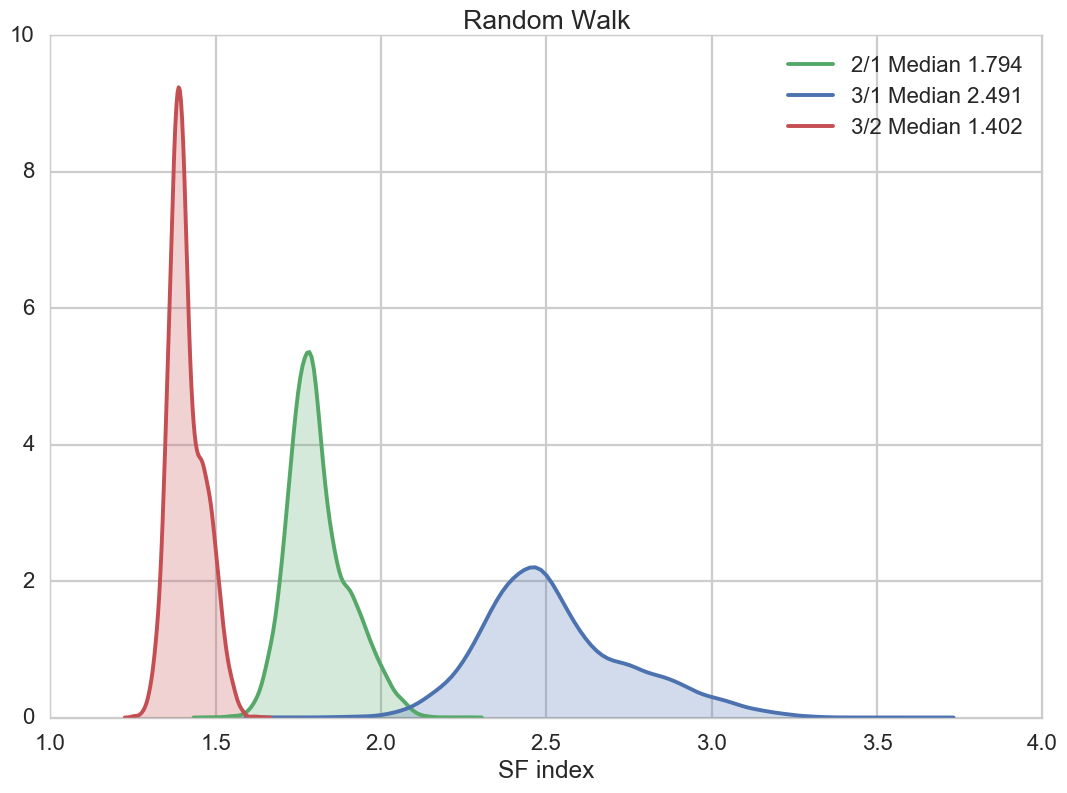

In [18]:
sns.kdeplot(RW_SF_IN['2/1'], shade=True, label="2/1 Median %.3f" % (np.median(RW_SF_IN['2/1'])), color='g')
sns.kdeplot(RW_SF_IN['3/1'], shade=True, label="3/1 Median %.3f" % (np.median(RW_SF_IN['3/1'])), color='b')
sns.kdeplot(RW_SF_IN['3/2'], shade=True, label="3/2 Median %.3f" % (np.median(RW_SF_IN['3/2'])), color='r')
plt.title('Random Walk')
plt.xlabel('SF index')
plt.show()

In [19]:
RN_SF_JM = {'2/1':[], '3/1':[], '3/2':[]}
RN_SF_IN = {'2/1':[], '3/1':[], '3/2':[]}
for k,lc in enumerate(RN_LCS):
    print '\r %i' % (k+1),
    time , mag = lc[:,0], lc[:,1]
    ## calculate SF
    #tau, SF84_1, SF84_2, SF84_3 = structure_function_jm(time, mag)
    mag_int, time_int, sf, sf2, sf3 = \
                                structure_function_in(time, mag)
    ## convert to log
    #SF84_1_log = np.log10(np.trim_zeros(SF84_1))
    #SF84_2_log = np.log10(np.trim_zeros(SF84_2))
    #SF84_3_log = np.log10(np.trim_zeros(SF84_3))
    sf_log = np.log10(np.trim_zeros(sf))
    sf2_log = np.log10(np.trim_zeros(sf2))
    sf3_log = np.log10(np.trim_zeros(sf3))
    ## fit linear rel
    #m_21_jm, m_31_jm, m_32_jm, b_21_jm, b_31_jm, b_32_jm =\
    #                            SF_ratios(SF84_1_log, SF84_2_log, SF84_3_log)
    m_21_in, m_31_in, m_32_in, b_21_in, b_31_in, b_32_in =\
                                SF_ratios(sf_log, sf2_log, sf3_log)
        
    #RW_SF_JM['2/1'].append(m_21_jm)
    #RW_SF_JM['3/1'].append(m_31_jm)
    #RW_SF_JM['3/2'].append(m_32_jm)
    RN_SF_IN['2/1'].append(m_21_in)
    RN_SF_IN['3/1'].append(m_31_in)
    RN_SF_IN['3/2'].append(m_32_in)
    
    ## plots
    if False:
        f, ax = plt.subplots(2)
        ax[0].plot(time, mag, 'k.')
        ax[1].plot(SF84_1_log, SF84_3_log, 'g.', label='JM')
        ax[1].plot(sf_log, sf3_log, 'b.', label='IN')

        SF_jm_x = np.linspace(SF84_1_log.min(), SF84_1_log.max(), 1000)
        ax[1].plot(SF_jm_x, SF_jm_x * m_31_jm + b_31_jm, 'r-', label=m_31_jm)
        SF_in_x = np.linspace(sf_log.min(), sf_log.max(), 1000)
        ax[1].plot(SF_in_x, SF_in_x * m_31_in + b_31_in, 'r--', label=m_31_in)

        ax[1].legend(loc='lower right')
    plt.show()
    
RN_SF_JM = pd.DataFrame(RN_SF_JM)
RN_SF_IN = pd.DataFrame(RN_SF_IN)

 10000


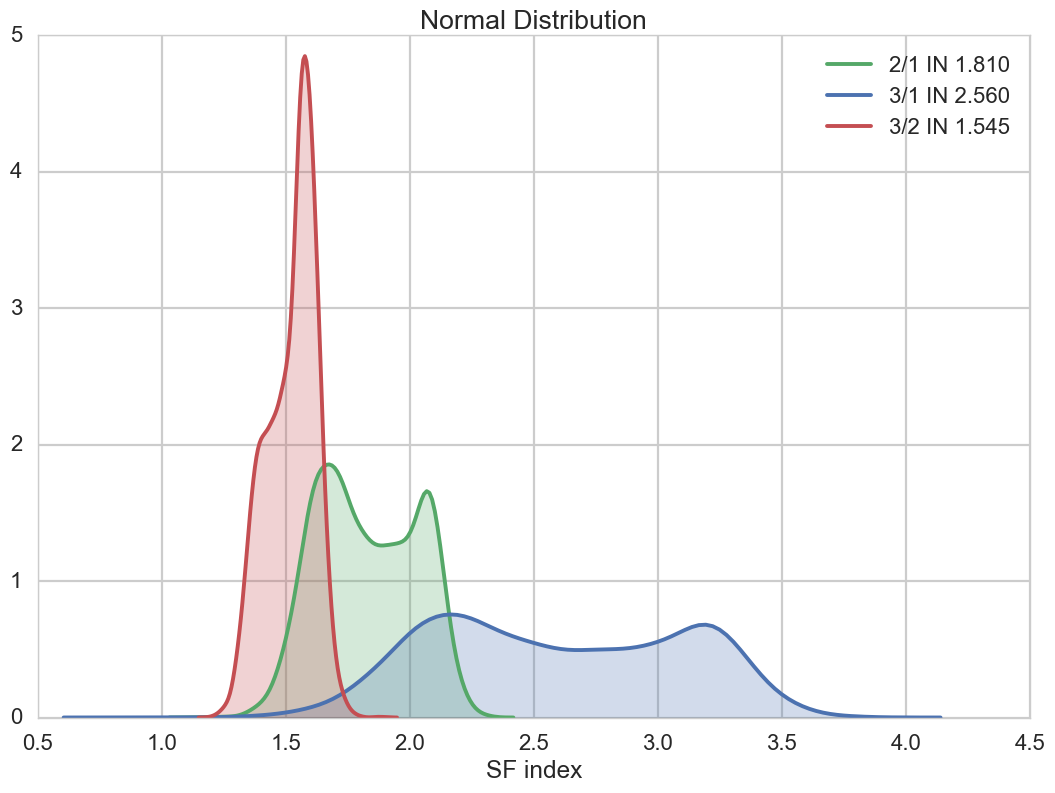

In [20]:
sns.kdeplot(RN_SF_IN['2/1'], shade=True, label="2/1 IN %.3f" % (np.median(RN_SF_IN['2/1'])), color='g')
sns.kdeplot(RN_SF_IN['3/1'], shade=True, label="3/1 IN %.3f" % (np.median(RN_SF_IN['3/1'])), color='b')
sns.kdeplot(RN_SF_IN['3/2'], shade=True, label="3/2 IN %.3f" % (np.median(RN_SF_IN['3/2'])), color='r')
plt.title('Normal Distribution')
plt.xlabel('SF index')
plt.show()

In [21]:
M_SF_JM = {'2/1':[], '3/1':[], '3/2':[]}
M_SF_IN = {'2/1':[], '3/1':[], '3/2':[]}
for k,lc in enumerate(M_LCS):
    print '\r %i' % (k+1),
    time , mag = lc['#MJD'], lc['Mag']
    ## calculate SF
    #tau, SF84_1, SF84_2, SF84_3 = structure_function_jm(time, mag)
    mag_int, time_int, sf, sf2, sf3 = \
                                structure_function_in(time, mag)
    ## convert to log
    #SF84_1_log = np.log10(np.trim_zeros(SF84_1))
    #SF84_2_log = np.log10(np.trim_zeros(SF84_2))
    #SF84_3_log = np.log10(np.trim_zeros(SF84_3))
    sf_log = np.log10(np.trim_zeros(sf))
    sf2_log = np.log10(np.trim_zeros(sf2))
    sf3_log = np.log10(np.trim_zeros(sf3))
    ## fit linear rel
    #m_21_jm, m_31_jm, m_32_jm, b_21_jm, b_31_jm, b_32_jm =\
    #                            SF_ratios(SF84_1_log, SF84_2_log, SF84_3_log)
    m_21_in, m_31_in, m_32_in, b_21_in, b_31_in, b_32_in =\
                                SF_ratios(sf_log, sf2_log, sf3_log)
        
    #M_SF_JM['2/1'].append(m_21_jm)
    #M_SF_JM['3/1'].append(m_31_jm)
    #M_SF_JM['3/2'].append(m_32_jm)
    M_SF_IN['2/1'].append(m_21_in)
    M_SF_IN['3/1'].append(m_31_in)
    M_SF_IN['3/2'].append(m_32_in)
    
    ## plots
    if False:
        f, ax = plt.subplots(2)
        ax[0].plot(time, mag, 'k.')
        ax[1].plot(SF84_1_log, SF84_3_log, 'g.', label='JM')
        ax[1].plot(sf_log, sf3_log, 'b.', label='IN')

        SF_jm_x = np.linspace(SF84_1_log.min(), SF84_1_log.max(), 1000)
        ax[1].plot(SF_jm_x, SF_jm_x * m_31_jm + b_31_jm, 'r-', label=m_31_jm)
        SF_in_x = np.linspace(sf_log.min(), sf_log.max(), 1000)
        ax[1].plot(SF_in_x, SF_in_x * m_31_in + b_31_in, 'r--', label=m_31_in)

        ax[1].legend(loc='lower right')
    plt.show()
    
#M_SF_JM = pd.DataFrame(M_SF_JM)
M_SF_IN = pd.DataFrame(M_SF_IN)

 118


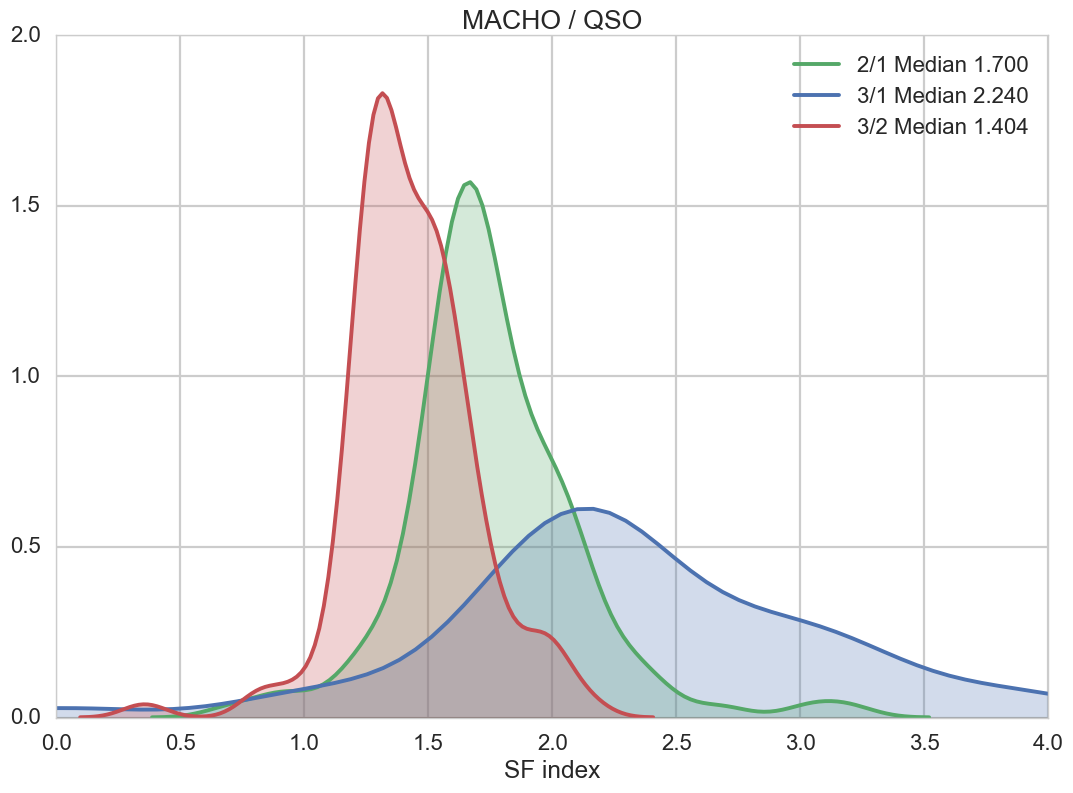

In [22]:
sns.kdeplot(M_SF_IN['2/1'], shade=True, label="2/1 Median %.3f" % (np.median(M_SF_IN['2/1'])), color='g')
sns.kdeplot(M_SF_IN['3/1'], shade=True, label="3/1 Median %.3f" % (np.median(M_SF_IN['3/1'])), color='b')
sns.kdeplot(M_SF_IN['3/2'], shade=True, label="3/2 Median %.3f" % (np.median(M_SF_IN['3/2'])), color='r')
plt.title('MACHO / QSO')
plt.xlabel('SF index')
plt.xlim(0,4)
plt.show()

In [23]:
M_SF_JM_NV = {'2/1':[], '3/1':[], '3/2':[]}
M_SF_IN_NV = {'2/1':[], '3/1':[], '3/2':[]}
for k,lc in enumerate(M_LCS_NV):
    print '\r %i' % (k+1),
    time , mag = lc['#MJD'], lc['Mag']
    ## calculate SF
    #tau, SF84_1, SF84_2, SF84_3 = structure_function_jm(time, mag)
    mag_int, time_int, sf, sf2, sf3 = \
                                structure_function_in(time, mag)
    ## convert to log
    #SF84_1_log = np.log10(np.trim_zeros(SF84_1))
    #SF84_2_log = np.log10(np.trim_zeros(SF84_2))
    #SF84_3_log = np.log10(np.trim_zeros(SF84_3))
    sf_log = np.log10(np.trim_zeros(sf))
    sf2_log = np.log10(np.trim_zeros(sf2))
    sf3_log = np.log10(np.trim_zeros(sf3))
    ## fit linear rel
    #m_21_jm, m_31_jm, m_32_jm, b_21_jm, b_31_jm, b_32_jm =\
    #                            SF_ratios(SF84_1_log, SF84_2_log, SF84_3_log)
    m_21_in, m_31_in, m_32_in, b_21_in, b_31_in, b_32_in =\
                                SF_ratios(sf_log, sf2_log, sf3_log)
        
    #M_SF_JM['2/1'].append(m_21_jm)
    #M_SF_JM['3/1'].append(m_31_jm)
    #M_SF_JM['3/2'].append(m_32_jm)
    M_SF_IN_NV['2/1'].append(m_21_in)
    M_SF_IN_NV['3/1'].append(m_31_in)
    M_SF_IN_NV['3/2'].append(m_32_in)
    
    ## plots
    if False:
        f, ax = plt.subplots(2)
        ax[0].plot(time, mag, 'k.')
        ax[1].plot(SF84_1_log, SF84_3_log, 'g.', label='JM')
        ax[1].plot(sf_log, sf3_log, 'b.', label='IN')

        SF_jm_x = np.linspace(SF84_1_log.min(), SF84_1_log.max(), 1000)
        ax[1].plot(SF_jm_x, SF_jm_x * m_31_jm + b_31_jm, 'r-', label=m_31_jm)
        SF_in_x = np.linspace(sf_log.min(), sf_log.max(), 1000)
        ax[1].plot(SF_in_x, SF_in_x * m_31_in + b_31_in, 'r--', label=m_31_in)

        ax[1].legend(loc='lower right')
    plt.show()
    
#M_SF_JM = pd.DataFrame(M_SF_JM)
M_SF_IN_NV = pd.DataFrame(M_SF_IN_NV)

 1220


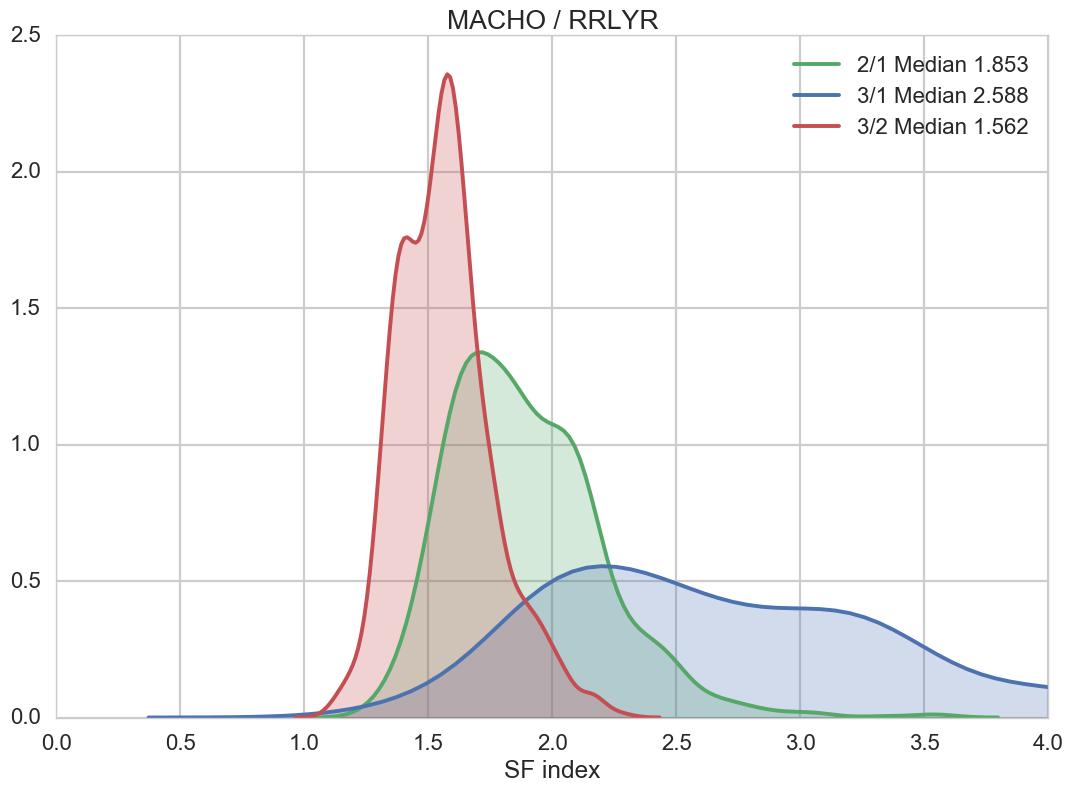

In [24]:
sns.kdeplot(M_SF_IN_NV['2/1'], shade=True, label="2/1 Median %.3f" % (np.median(M_SF_IN_NV['2/1'])), color='g')
sns.kdeplot(M_SF_IN_NV['3/1'], shade=True, label="3/1 Median %.3f" % (np.median(M_SF_IN_NV['3/1'])), color='b')
sns.kdeplot(M_SF_IN_NV['3/2'], shade=True, label="3/2 Median %.3f" % (np.median(M_SF_IN_NV['3/2'])), color='r')
plt.title('MACHO / RRLYR')
plt.xlabel('SF index')
plt.xlim(0,4)
plt.show()